# Generate embeddings for Ray documents using Ray Data

# Prerequisites

0. Create an Anyscale workspace and disable autoscaling by deleting the worker node types.

1. Setup a Postgres service:

```bash
# path: kuberay-rag-demo/anyscale/
bash setup-pgvector.sh

# path: kuberay-rag-demo/anyscale/
# Initialize the schema.
sudo -u postgres psql -f vector-768.sql
```

2. Download the Ray documents by running:
    
```bash
# Please download and unzip the `ray-assistant-data` directory into the NFS `/mnt/shared_storage` to allow
# all Ray nodes in the cluster access to the Ray docs.
wget -O - https://storage.googleapis.com/ray-docs-embedding-postgres-dump/ray_docs.tar.gz | tar -xz
```

3. Create a `.env` file in the same directory as this notebook to initialize the `DB_CONNECTION_STRING` variable for connecting to Postgres. You can use `DB_CONNECTION_STRING="dbname=postgres user=postgres host=localhost password=postgres"` for this demo.

In [2]:
import ray
import matplotlib.pyplot as plt
import json
import os
import psycopg
from dotenv import load_dotenv
from pathlib import Path
from bs4 import BeautifulSoup, NavigableString
from functools import partial
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from ray.data import ActorPoolStrategy
from pgvector.psycopg import register_vector

In [3]:
# Load environment variables from .env file in the same directory.
load_dotenv()

True

In [ ]:
ray.init(runtime_env={
    "env_vars": {
        "DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
    },
})
ray.cluster_resources()

# Data

Before we can start building our RAG application, we need to first create our vector DB that will contain our processed data sources.

<img width="1000" src="https://images.ctfassets.net/xjan103pcp94/3q5HUANQ4kS0V23cgEP0JF/ef3b62c5bc5c5c11b734fd3b73f6ea28/image3.png">

## Load data

We’re going to then load our docs contents into a [Ray Dataset](https://docs.ray.io/en/latest/data/data.html) so that we can perform operations at scale on them (ex. embed, index, etc.). With large data sources, models and application serving needs, scale is a day-1 priority for LLM applications. We want to build our applications in such a way that they can scale as our needs grow without us having to change our code later.

In [5]:
# Path for Ray docs. Note that access to Ray docs is required not only by the Ray head but also by the worker nodes.
# Therefore, we need to place the Ray docs into shared storage.
ray_docs_path = Path("/mnt/shared_storage/ray-assistant-data/docs.ray.io/en/master/")
assert ray_docs_path.exists()

In [6]:
ds = ray.data.from_items([{"path": path} for path in ray_docs_path.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3033 documents


## Sections

Now that we have a dataset of all the paths to the html files, we're going to develop some functions that can appropriately extract the content from these files. We want to do this in a generalized manner so that we can perform this extraction across all of our docs pages (and so you can use it for your own data sources). Our process is to first identify the sections in our html page and then extract the text in between them. We save all of this into a list of dictionaries that map the text within a section to a specific url with a section anchor id.

<img width="800" src="https://images.ctfassets.net/xjan103pcp94/1eFnKmG5xqPIFtPupZ327X/f6152723e18322b90aaa8be5d2d5a6e4/image5.png">

In [7]:
# Utility functions to extract sections from a Ray document.
def extract_sections(record):
    with open(record["path"], "r", encoding="utf-8") as html_file:
        soup = BeautifulSoup(html_file, "html.parser")
    sections = soup.find_all("section")
    section_list = []
    for section in sections:
        section_id = section.get("id")
        section_text = extract_text_from_section(section)
        if section_id:
            uri = path_to_uri(path=record["path"])
            section_list.append({"source": f"{uri}#{section_id}", "text": section_text})
    return section_list

def extract_text_from_section(section):
    texts = []
    for elem in section.children:
        if isinstance(elem, NavigableString):
            if elem.strip():
                texts.append(elem.strip())
        elif elem.name == "section":
            continue
        else:
            texts.append(elem.get_text().strip())
    return "\n".join(texts)

def path_to_uri(path, scheme="https://", domain="docs.ray.io"):
    return scheme + domain + str(path).split(domain)[-1]

In [8]:
sample_ray_doc = Path(ray_docs_path, "rllib/rllib-env.html")
sections = extract_sections({"path": sample_ray_doc})
print(f"Extract {len(sections)} sections from the doc {sample_ray_doc}.")
print(f"1st section in the Ray doc:\n{json.dumps(sections[0], indent=2)}")

Extract 17 sections from the doc /mnt/shared_storage/ray-assistant-data/docs.ray.io/en/master/rllib/rllib-env.html.
1st section in the Ray doc:
{
  "source": "https://docs.ray.io/en/master/rllib/rllib-env.html#environments",
  "text": "\nEnvironments#\nRLlib works with several different types of environments, including Farama-Foundation Gymnasium, user-defined, multi-agent, and also batched environments.\nTip\nNot all environments work with all algorithms. Check out the algorithm overview for more information.\n"
}


We can apply this extraction process (extract_section) in parallel to all the file paths in our dataset with just one line using Ray Data's [flat_map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.flat_map.html):

In [9]:
# Extract sections
sections_ds = ds.flat_map(extract_sections)
sections_ds.count()

3033

In [ ]:
section_lengths = []
for section in sections_ds.take_all():
    section_lengths.append(len(section["text"]))

## Chunk data

We now have a list of sections (with text and source of each section) but we shouldn't directly use this as context to our RAG application just yet. The text lengths of each section are all varied and many are quite large chunks. 

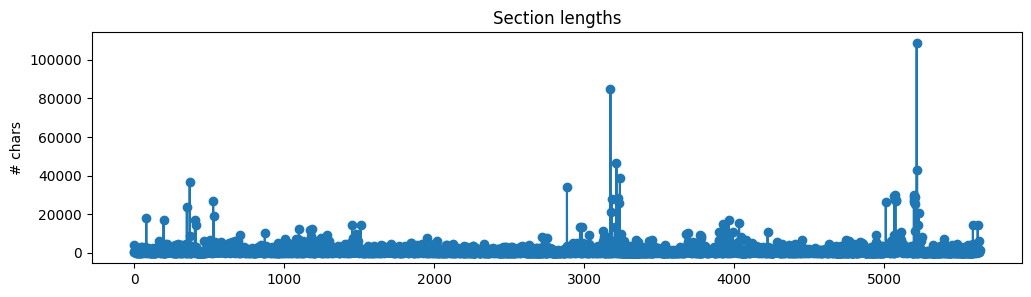

In [11]:
# Plot
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

If we were to use these large sections, then we'd be inserting a lot of noisy/unwanted context and because all LLMs have a maximum context length, we wouldn't be able to fit too much other relevant context. So instead, we're going to split the text within each section into smaller chunks. Intuitively, smaller chunks will encapsulate single/few concepts and will be less noisy compared to larger chunks. We're going to choose some typical text splitting values (ex. chunk_size=300) to create our chunks for now but we'll be experimenting with a wider range of values later.

In [12]:
# Text splitter
chunk_size = 300
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len)

In [13]:
# Chunk a sample section
sample_section = sections_ds.take(1)[0]
chunks = text_splitter.create_documents(
    texts=[sample_section["text"]], 
    metadatas=[{"source": sample_section["source"]}])
print(f"A sample chunk:\n{chunks[0]}")

2024-03-29 03:29:31,097	INFO dataset.py:2368 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-03-29 03:29:31,102	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-03-29_03-15-37_448370_6162/logs/ray-data.log
2024-03-29 03:29:31,103	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> LimitOperator[limit=1]



- FlatMap(extract_sections) 1:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

A sample chunk:
page_content='ray.serve.metrics.Gauge.info#\nproperty Gauge.info: Dict[str, Any]#\nReturn the information of this metric.\nExample\n>>> from ray.util.metrics import Counter\n>>> counter = Counter("name", description="desc")\n>>> print(counter.info)' metadata={'source': 'https://docs.ray.io/en/master/serve/api/doc/ray.serve.metrics.Gauge.info.html#ray-serve-metrics-gauge-info'}


While chunking our dataset is relatively fast, let’s wrap the chunking logic into a function so that we can apply the workload at scale so that chunking remains just as fast as our data sources grow:


In [14]:
def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
    chunks = text_splitter.create_documents(
        texts=[section["text"]], 
        metadatas=[{"source": section["source"]}])
    return [{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks]

In [15]:
# Scale chunking
chunks_ds = sections_ds.flat_map(partial(
    chunk_section, 
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap))
print(f"{chunks_ds.count()} chunks")
chunks_ds.show(1)

2024-03-29 03:29:38,735	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-03-29_03-15-37_448370_6162/logs/ray-data.log
2024-03-29 03:29:38,736	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> LimitOperator[limit=1]



3033 chunks


- FlatMap(extract_sections)->FlatMap(partial) 1:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

{'text': 'ray.serve.metrics.Gauge.info#\nproperty Gauge.info: Dict[str, Any]#\nReturn the information of this metric.\nExample\n>>> from ray.util.metrics import Counter\n>>> counter = Counter("name", description="desc")\n>>> print(counter.info)', 'source': 'https://docs.ray.io/en/master/serve/api/doc/ray.serve.metrics.Gauge.info.html#ray-serve-metrics-gauge-info'}


## Embed data

Now that we've created small chunks from our sections, we need a way to identify the most relevant ones for a given query. A very effective and quick method is to embed our data using a pretrained model and use the same model to embed the query. We can then compute the distance between all of the chunk embeddings and our query embedding to determine the top-k chunks. There are many different pretrained models to choose from to embed our data but the most popular ones can be discovered through [HuggingFace's Massive Text Embedding Benchmark (MTEB)](https://huggingface.co/spaces/mteb/leaderboard) leaderboard. These models were pretrained on very large text corpus through tasks such as next/masked token prediction which allowed them to learn to represent subtokens in N dimensions and capture semantic relationships. We can leverage this to represent our data and identify the most relevant contexts to use to answer a given query. We're using Langchain's Embedding wrappers ([HuggingFaceEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.huggingface.HuggingFaceEmbeddings.html) and [OpenAIEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.openai.OpenAIEmbeddings.html)) to easily load the models and embed our document chunks.

**Note**: embeddings aren't the only way to determine the more relevant chunks. We could also use an LLM to decide! However, because LLMs are much larger than these embedding models and have maximum context lengths, it's better to use embeddings to retrieve the top k chunks. And then we could use LLMs on the fewer k chunks to determine the <k chunks to use as the context to answer our query. We could also use reranking (ex. [Cohere Rerank](https://txt.cohere.com/rerank/)) to further identify the most relevant chunks to use. We could also combine embeddings with traditional information retrieval methods such as keyword matching, which could be useful for matching for unique tokens that may potentially be lost when embedding subtokens.

In [16]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            openai_api_base=os.environ["OPENAI_API_BASE"],
            openai_api_key=os.environ["OPENAI_API_KEY"])
    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=embedding_model_name,  # also works with model_path
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs)
    return embedding_model

In [17]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(
            embedding_model_name=model_name,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"device": "cuda", "batch_size": 100})
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

Here we're able to embed our chunks at scale by using [map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html). All we had to do was define the `batch_size` and the compute resources.

In [18]:
# Embed chunks
embedding_model_name = "thenlper/gte-base"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=1))

2024-03-29 03:29:49,614	WARNING util.py:561 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.


In [19]:
# Sample an embedding
sample = embedded_chunks.take(1)
print ("embedding size:", len(sample[0]["embeddings"]))
print (sample[0]["text"])

2024-03-29 03:29:50,285	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-03-29_03-15-37_448370_6162/logs/ray-data.log
2024-03-29 03:29:50,286	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> LimitOperator[limit=1]

modules.json: 100%|██████████| 385/385 [00:00<00:00, 41.9kB/s]
README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]
README.md: 100%|██████████| 68.1k/68.1k [00:00<00:00, 1.07MB/s]
sentence_bert_config.json: 100%|██████████| 57.0/57.0 [00:00<00:00, 31.8kB/s]
config.json: 100%|██████████| 618/618 [00:00<00:00, 376kB/s]
model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]
model.safetensors:  10%|▉         | 21.0M/219M [00:00<00:01, 158MB/s]
model.safetensors:  24%|██▍       | 52.4M/219M [00:00<00:00, 217MB/s]
model.safetensors:  38%|███▊      | 83.9M/219M [00:00<

- FlatMap(extract_sections)->FlatMap(partial) 1:   0%|          | 0/200 [00:00<?, ?it/s]

- MapBatches(EmbedChunks) 2:   0%|          | 0/200 [00:00<?, ?it/s]

- limit=1 3:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

embedding size: 768
Pattern: Using ray.wait to limit the number of pending tasks#
In this pattern, we use ray.wait() to limit the number of pending tasks.
If we continuously submit tasks faster than their process time, we will accumulate tasks in the pending task queue, which can eventually cause OOM.


(MapWorker(MapBatches(EmbedChunks)) pid=20238) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'embeddings', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapWorker(MapBatches(EmbedChunks)) pid=20238) - Expand out each key-value pair in the dict column into its own column
(MapWorker(MapBatches(EmbedChunks)) pid=20238) - Replace `None` values with an Arrow supported data type
(MapWorker(MapBatches(EmbedChunks)) pid=20238) 


## Index data

Now that we have our embedded chunks, we need to index (store) them somewhere so that we can retrieve them quickly for inference. While there are many popular vector database options, we're going to use [Postgres with pgvector](https://github.com/pgvector/pgvector) for it's simplificty and performance. We'll create a table (`document`) and write the (`text`, `source`, `embedding`) triplets for each embedded chunk we have.

<img width="700" src="https://images.ctfassets.net/xjan103pcp94/3z1ryYkOtUjj6N1IuavJPf/ae60dc4a10c94e2cc928c38701befb51/image2.png">

In [21]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

And once again, we can use Ray Data’s [map_batches](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html) to perform this indexing in parallel:

In [22]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    num_cpus=1,
    compute=ActorPoolStrategy(size=6),
).materialize()

2024-03-29 03:31:29,614	WARNING util.py:561 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-03-29 03:31:29,622	INFO streaming_executor.py:115 -- Starting execution of Dataset. Full log is in /tmp/ray/session_2024-03-29_03-15-37_448370_6162/logs/ray-data.log
2024-03-29 03:31:29,623	INFO streaming_executor.py:116 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]



- FlatMap(extract_sections)->FlatMap(partial) 1:   0%|          | 0/200 [00:00<?, ?it/s]

- MapBatches(EmbedChunks) 2:   0%|          | 0/200 [00:00<?, ?it/s]

- MapBatches(StoreResults) 3:   0%|          | 0/200 [00:00<?, ?it/s]

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(MapWorker(MapBatches(EmbedChunks)) pid=20959) Could not construct Arrow block from numpy array; encountered values of unsupported numpy type `17` in column named 'embeddings', which cannot be casted to an Arrow data type. Falling back to using pandas block type, which is slower and consumes more memory. For maximum performance, consider applying the following suggestions before ingesting into Ray Data in order to use native Arrow block types:
(MapWorker(MapBatches(EmbedChunks)) pid=20959) - Expand out each key-value pair in the dict column into its own column
(MapWorker(MapBatches(EmbedChunks)) pid=20959) - Replace `None` values with an Arrow supported data type
(MapWorker(MapBatches(EmbedChunks)) pid=20959) 


MaterializedDataset(num_blocks=126, num_rows=0, schema=Unknown schema)

In [23]:
os.environ["SQL_DUMP_FP"] = f"/mnt/shared_storage/ray-assistant-data/{embedding_model_name.split('/')[-1]}_{chunk_size}_{chunk_overlap}.sql"

In [24]:
%%bash
# Dump the Postgres database to $SQL_DUMP_FP
echo $SQL_DUMP_FP
sudo -u postgres pg_dump -c > $SQL_DUMP_FP

# You don't need to generate the embeddings again if you have $SQL_DUMP_FP (gte-base_300_50.sql in this example).
# You can initialize Postgres with `sudo -u postgres psql -f $SQL_DUMP_FP`.

/mnt/shared_storage/ray-assistant-data/gte-base_300_50.sql
